In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from packaging import version
from tensorflow.keras import layers, models, backend as k
import seaborn as sns
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error as MSE, confusion_matrix
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
import tensorflow_datasets as tfds
import re
import string
import time

In [7]:
# https://www.tensorflow.org/datasets/splits
# The full 'train' and 'test' splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True, split=ri, as_supervised=True)
text_only_dataset_all = dataset_all.map(lambda x, y: x)

In [8]:
# Downloading and preparing dataset
tfds.as_dataframe(dataset_all.take(10), info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


In [9]:
# Check the categories
categories = dict(enumerate(info.features["label"].names))
print(f'Dictionary: ', categories)

Dictionary:  {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}


In [10]:
# Review Class Balance
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

In [11]:
# Custom stopwords function
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase, r'[%s]' % re.escape(string.punctuation), '')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*', '')

In [12]:
nltk.download('stopwords', quiet=True)
STOPWORDS = stopwords.words("english")

In [30]:
# Text Vectorization and Vocabulary Adaptation
def text_vectorization_and_adapt(text_dataset, max_tokens=None, standardize_fn=None, output_sequence_length=None):
    text_vectorization = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens,
        output_mode="int",
        standardize=standardize_fn,
        output_sequence_length=output_sequence_length
    )
    text_vectorization.adapt(text_dataset)
    return text_vectorization

In [31]:
# CNN with Multiple Filter Sizes
def create_multi_filter_model(vocab_size, output_sequence_length):
    tf.keras.backend.clear_session()
    inputs = tf.keras.Input(shape=(output_sequence_length,), dtype="int64")
    embedded = layers.Embedding(input_dim=vocab_size, output_dim=256, input_length=output_sequence_length)(inputs)

    convs = []
    for filter_size in [3, 4, 5]:
        conv = layers.Conv1D(128, filter_size, activation='relu')(embedded)
        pool = layers.GlobalMaxPooling1D()(conv)
        convs.append(pool)
    merged = layers.concatenate(convs, axis=1)

    x = layers.Dense(128, activation='relu')(merged)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(4, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# CNN with Residual Connections
def residual_block(x, filters, kernel_size=3):
    res = layers.Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
    res = layers.Conv1D(filters, kernel_size, padding='same')(res)
    x = layers.add([x, res])
    x = layers.Activation('relu')(x)
    return x

In [32]:
def create_residual_model(vocab_size, output_sequence_length):
    tf.keras.backend.clear_session()
    inputs = tf.keras.Input(shape=(output_sequence_length,), dtype="int64")
    embedded = layers.Embedding(input_dim=vocab_size, output_dim=256, input_length=output_sequence_length)(inputs)

    x = layers.Conv1D(128, 3, activation='relu', padding='same')(embedded)
    x = layers.MaxPooling1D(2)(x)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = layers.GlobalMaxPooling1D()(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(4, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

In [33]:
def attention_block(inputs):
    attention = layers.Dense(1, activation='tanh')(inputs)
    attention = layers.Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    attention = layers.RepeatVector(128)(attention)
    attention = layers.Permute([2, 1])(attention)
    output = layers.multiply([inputs, attention])
    return output

def create_attention_model(vocab_size, output_sequence_length):
    tf.keras.backend.clear_session()
    inputs = tf.keras.Input(shape=(output_sequence_length,), dtype="int64")
    embedded = layers.Embedding(input_dim=vocab_size, output_dim=256, input_length=output_sequence_length)(inputs)

    x = layers.Conv1D(128, 3, activation='relu')(embedded)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 3, activation='relu')(x)
    x = layers.GlobalMaxPooling1D()(x)

    attention = attention_block(x)

    x = layers.Dense(128, activation='relu')(attention)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(4, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model


In [34]:
def create_cnn_gru_model(vocab_size, output_sequence_length):
    tf.keras.backend.clear_session()
    inputs = tf.keras.Input(shape=(output_sequence_length,), dtype="int64")
    embedded = layers.Embedding(input_dim=vocab_size, output_dim=256, input_length=output_sequence_length)(inputs)

    x = layers.Conv1D(128, 3, activation='relu')(embedded)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 3, activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.GRU(128, return_sequences=False)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(4, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

In [35]:
# Train and evaluate the model
def train_and_evaluate_model(vocab_size, text_vectorization, output_sequence_length, model_name, model_fn):
    print(f"Starting experiment: {model_name} with vocab size {vocab_size}")

    # Prepare the dataset
    def vectorize_text(text, label):
        text = text_vectorization(text)
        return text, label

    vectorized_dataset = dataset_all.map(vectorize_text)
    vectorized_dataset = vectorized_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    # Split the dataset
    dataset_size = len(list(vectorized_dataset))
    train_size = int(0.8 * dataset_size)
    val_size = dataset_size - train_size

    train_dataset = vectorized_dataset.take(train_size).batch(32)
    val_dataset = vectorized_dataset.skip(train_size).take(val_size).batch(32)

    # Train the model
    model = model_fn(vocab_size, output_sequence_length)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(f"{model_name}.h5", save_best_only=True),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ]
    start_time = time.time()
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=200, callbacks=callbacks)
    training_time = time.time() - start_time

    # Evaluate on validation dataset
    val_loss, val_accuracy = model.evaluate(val_dataset)

    # Load the best model and evaluate on validation dataset
    model = models.load_model(f"{model_name}.h5")
    test_loss, test_accuracy = model.evaluate(val_dataset)

    # Collect final train accuracy and loss
    train_acc = history.history['accuracy'][-1]
    train_loss = history.history['loss'][-1]

    return {
        'model_name': model_name,
        'train_acc': train_acc,
        'train_loss': train_loss,
        'train_time': training_time,
        'val_acc': val_accuracy,
        'val_loss': val_loss,
        'test_acc': test_accuracy,
        'test_loss': test_loss,
        'history': history  # Ensure history is returned
    }

In [36]:
# Experiment configurations
experiments = [
    {"name": "multi_filter", "vocab_sizes": [5000, 10000, 20000], "standardize_fn": None, "output_sequence_length": 100, "model_fn": create_multi_filter_model},
    {"name": "residual", "vocab_sizes": [5000, 10000, 20000], "standardize_fn": None, "output_sequence_length": 100, "model_fn": create_residual_model},
    {"name": "attention", "vocab_sizes": [5000, 10000, 20000], "standardize_fn": None, "output_sequence_length": 100, "model_fn": create_attention_model},
    {"name": "cnn_gru", "vocab_sizes": [5000, 10000, 20000], "standardize_fn": None, "output_sequence_length": 100, "model_fn": create_cnn_gru_model}
]

In [37]:
# Collecting results for the models
all_results = []
for experiment in experiments:
    for vocab_size in experiment["vocab_sizes"]:
        try:
            text_vectorization = text_vectorization_and_adapt(
                dataset_all.map(lambda text, label: text),
                max_tokens=vocab_size,
                standardize_fn=experiment["standardize_fn"],
                output_sequence_length=experiment["output_sequence_length"]
            )
            results = train_and_evaluate_model(vocab_size, text_vectorization, experiment["output_sequence_length"], experiment["name"], experiment["model_fn"])
            all_results.append(results)
        except ValueError as e:
            print(f"Error with vocab_size {vocab_size}: {e}")

Starting experiment: multi_filter with vocab size 5000
Epoch 1/200
3190/3190 [==============================] - 34s 9ms/step - loss: 0.4546 - accuracy: 0.8385 - val_loss: 0.3404 - val_accuracy: 0.8826
Epoch 2/200
  10/3190 [..............................] - ETA: 17s - loss: 0.4417 - accuracy: 0.8438

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3190/3190 [==============================] - 20s 6ms/step - loss: 0.3303 - accuracy: 0.8928 - val_loss: 0.3322 - val_accuracy: 0.8892
Epoch 3/200
3190/3190 [==============================] - 20s 6ms/step - loss: 0.2955 - accuracy: 0.9060 - val_loss: 0.3449 - val_accuracy: 0.8910
Epoch 4/200
3190/3190 [==============================] - 20s 6ms/step - loss: 0.2636 - accuracy: 0.9170 - val_loss: 0.4090 - val_accuracy: 0.8901
Epoch 5/200
3190/3190 [==============================] - 20s 6ms/step - loss: 0.2331 - accuracy: 0.9284 - val_loss: 0.5301 - val_accuracy: 0.8841
Epoch 6/200
798/798 [==============================] - 3s 3ms/step - loss: 0.3322 - accuracy: 0.8892
Starting experiment: multi_filter with vocab size 10000
Epoch 1/200
3190/3190 [==============================] - 30s 9ms/step - loss: 0.4376 - accuracy: 0.8461 - val_loss: 0.3199 - val_accuracy: 0.8918
Epoch 2/200
3190/3190 [==============================] - 21s 6ms/step - loss: 0.3005 - accuracy: 0.9034 - val_loss: 0.3176 - 

In [38]:
# Adjust display settings for better alignment
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Create a DataFrame to display the results
df = pd.DataFrame(all_results)

# Display the DataFrame
print(df)

      model_name  train_acc  train_loss  train_time   val_acc  val_loss  test_acc  test_loss                                            history
0   multi_filter   0.938754    0.202763  133.952183  0.886481  0.589971  0.889185   0.332228  <keras.src.callbacks.History object at 0x7ff32...
1   multi_filter   0.962706    0.132340  131.624944  0.891497  0.676519  0.896121   0.317648  <keras.src.callbacks.History object at 0x7ff32...
2   multi_filter   0.959639    0.142174  115.079098  0.897688  0.548854  0.901097   0.308771  <keras.src.callbacks.History object at 0x7ff32...
3       residual   0.886834    0.395314  100.465831  0.880368  0.401959  0.883817   0.330450  <keras.src.callbacks.History object at 0x7ff32...
4       residual   0.909032    0.327231  101.234022  0.896865  0.351980  0.899138   0.304928  <keras.src.callbacks.History object at 0x7ff23...
5       residual   0.923766    0.296343  123.312352  0.883621  0.463878  0.895925   0.303612  <keras.src.callbacks.History object at 0x7

Model: multi_filter, Vocab Size: multi_filter, History Data: {'loss': [0.4546104669570923, 0.33027875423431396, 0.29545268416404724, 0.2636182904243469, 0.23311367630958557, 0.20276294648647308], 'accuracy': [0.838538408279419, 0.8928389549255371, 0.9059953093528748, 0.917006254196167, 0.9283993244171143, 0.9387539029121399], 'val_loss': [0.34035053849220276, 0.3322280943393707, 0.3449135422706604, 0.4089815020561218, 0.530147910118103, 0.5899708867073059], 'val_accuracy': [0.882641077041626, 0.8891849517822266, 0.8909874558448792, 0.8901253938674927, 0.8840517401695251, 0.8864811658859253]}
Model: multi_filter, Vocab Size: multi_filter, History Data: {'loss': [0.4375818073749542, 0.30045318603515625, 0.2510562241077423, 0.20480425655841827, 0.164328932762146, 0.1323404610157013], 'accuracy': [0.8460618853569031, 0.9034286737442017, 0.9213460087776184, 0.9368926286697388, 0.9515869617462158, 0.9627057313919067], 'val_loss': [0.31986796855926514, 0.3176479935646057, 0.36417776346206665,

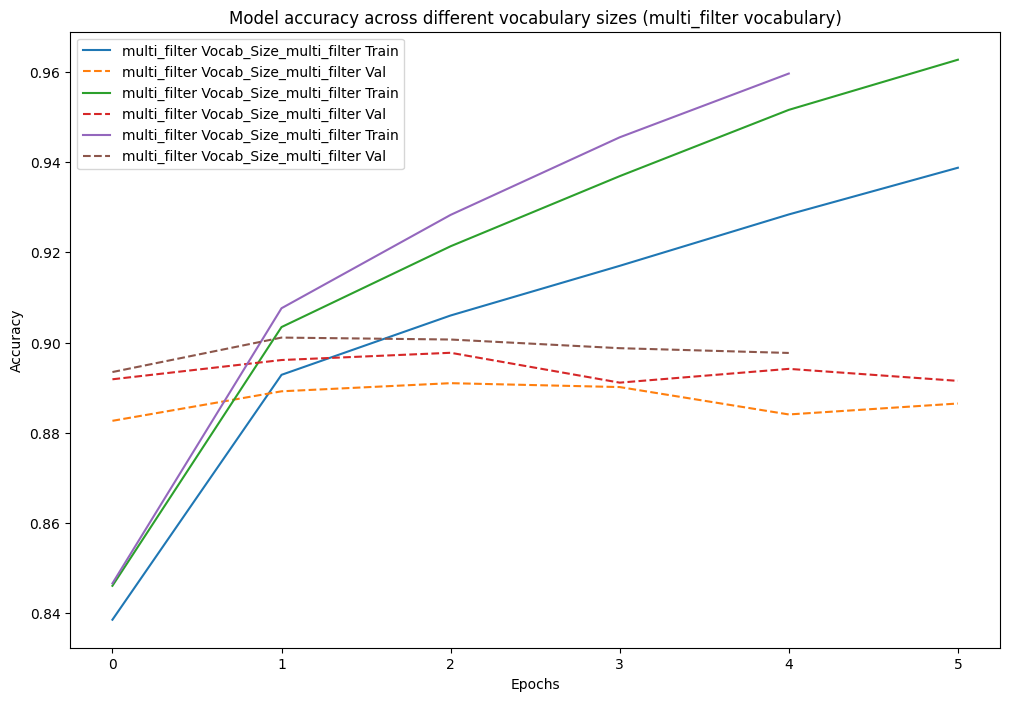

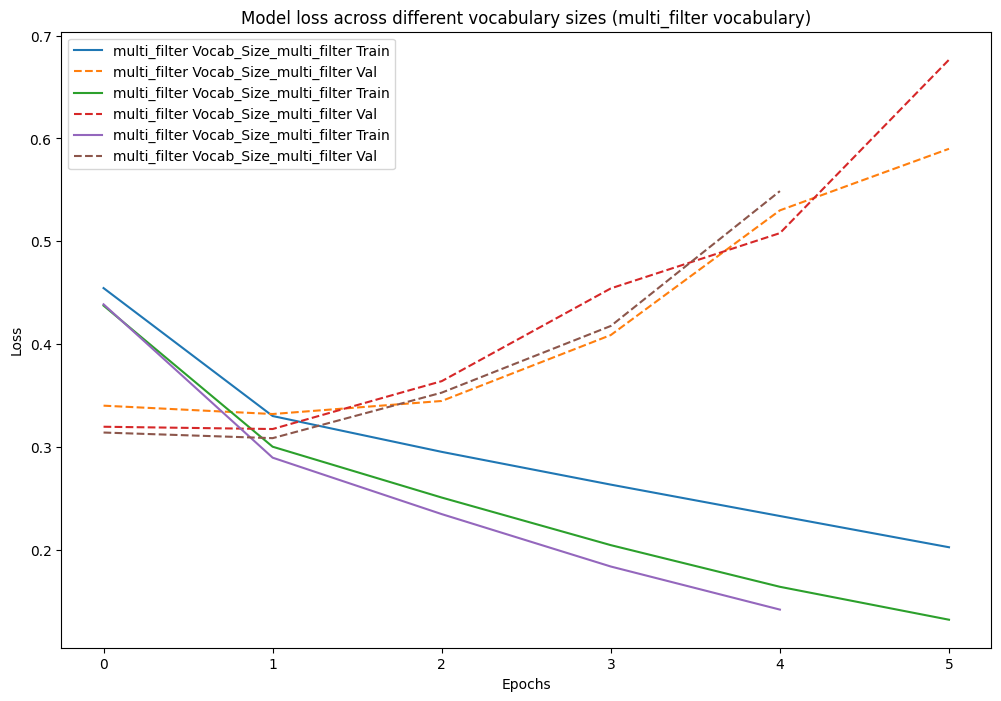

Model: residual, Vocab Size: residual, History Data: {'loss': [0.4455096125602722, 0.34269988536834717, 0.35293877124786377, 0.3717590570449829, 0.395314484834671], 'accuracy': [0.8423981070518494, 0.8903703093528748, 0.8914870619773865, 0.8893906474113464, 0.8868338465690613], 'val_loss': [0.33045023679733276, 0.34129130840301514, 0.36577144265174866, 0.378998726606369, 0.4019589424133301], 'val_accuracy': [0.8838165998458862, 0.8878918290138245, 0.884835422039032, 0.8844043612480164, 0.8803683519363403]}
Model: residual, Vocab Size: residual, History Data: {'loss': [0.43106359243392944, 0.3093982934951782, 0.3124304711818695, 0.3194742202758789, 0.32723134756088257], 'accuracy': [0.8480897545814514, 0.9024882316589355, 0.9071512818336487, 0.9086402654647827, 0.9090321063995361], 'val_loss': [0.3208484649658203, 0.30492761731147766, 0.3222002387046814, 0.3284565806388855, 0.3519800305366516], 'val_accuracy': [0.8894984126091003, 0.8991379141807556, 0.8893024921417236, 0.89706110954284

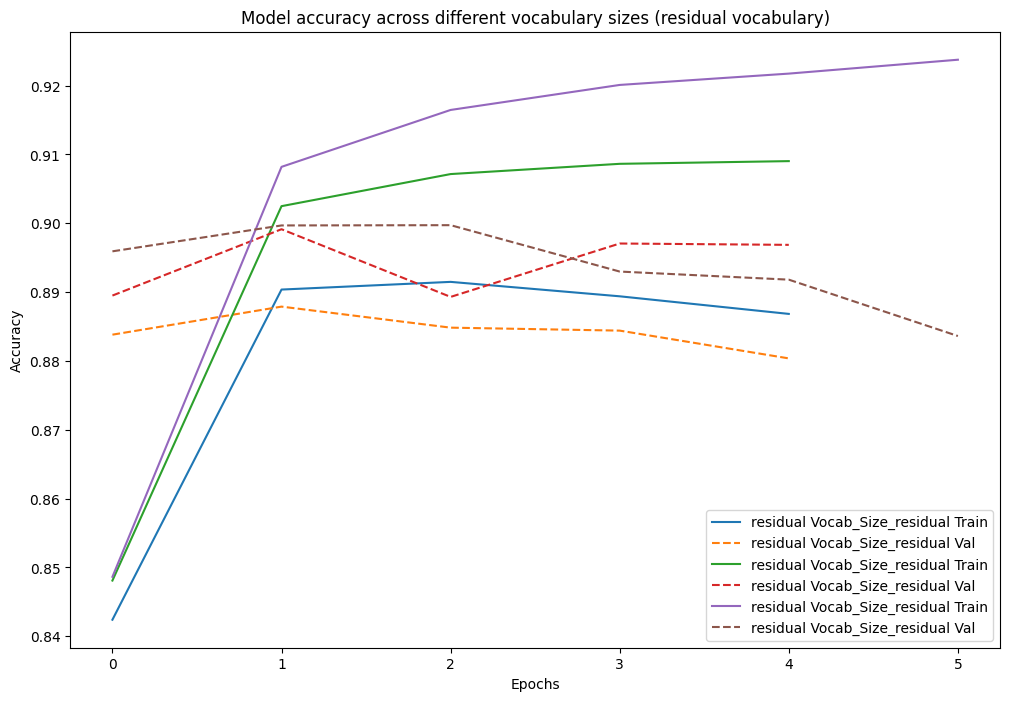

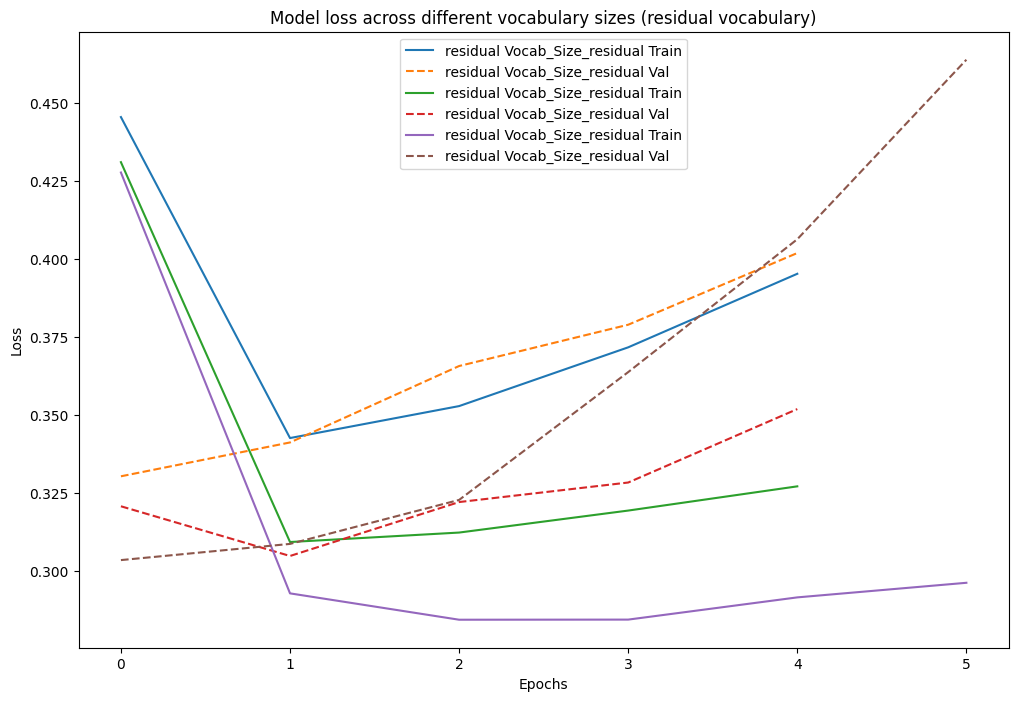

Model: attention, Vocab Size: attention, History Data: {'loss': [0.4678674638271332, 0.33981555700302124, 0.31750789284706116, 0.30703404545783997, 0.30058515071868896, 0.2969110310077667], 'accuracy': [0.2690974473953247, 0.27056077122688293, 0.27074018120765686, 0.2709553837776184, 0.27096670866012573, 0.27109527587890625], 'val_loss': [0.3443528115749359, 0.3325969874858856, 0.33609887957572937, 0.3552488386631012, 0.381824791431427, 0.4367147982120514], 'val_accuracy': [0.2692103087902069, 0.26943570375442505, 0.2695288062095642, 0.2692740261554718, 0.26902535557746887, 0.26934996247291565]}
Model: attention, Vocab Size: attention, History Data: {'loss': [0.44896379113197327, 0.3114059865474701, 0.28122201561927795, 0.26620110869407654, 0.2558462619781494], 'accuracy': [0.2692263424396515, 0.2708629369735718, 0.2712544798851013, 0.27149173617362976, 0.27162060141563416], 'val_loss': [0.34968283772468567, 0.3152156472206116, 0.3652600049972534, 0.35066062211990356, 0.385600447654724

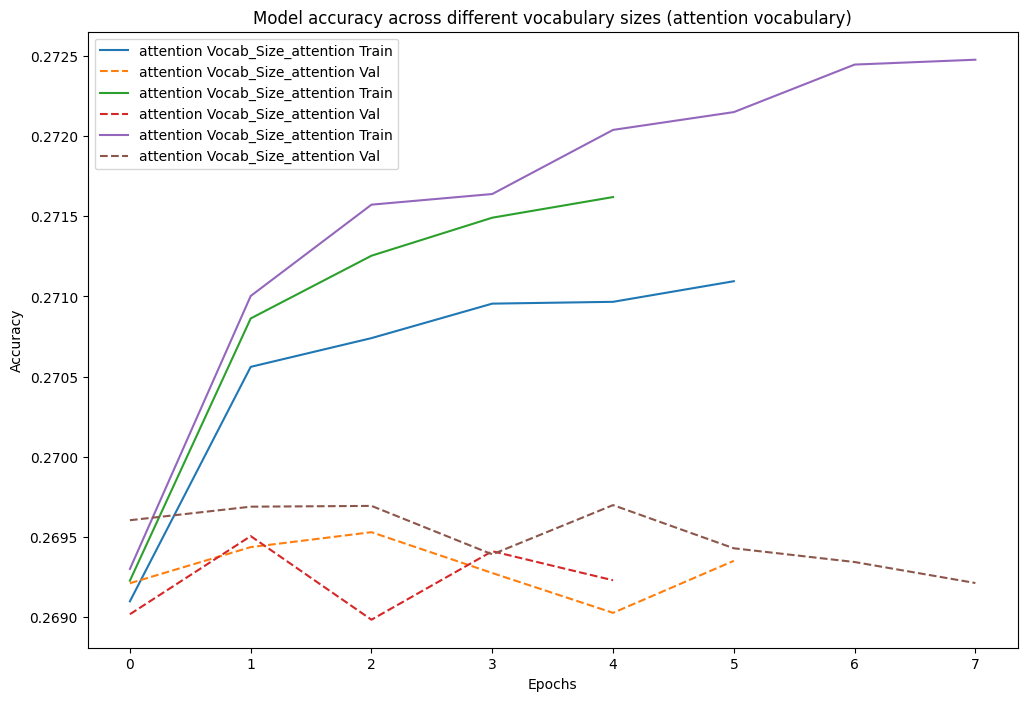

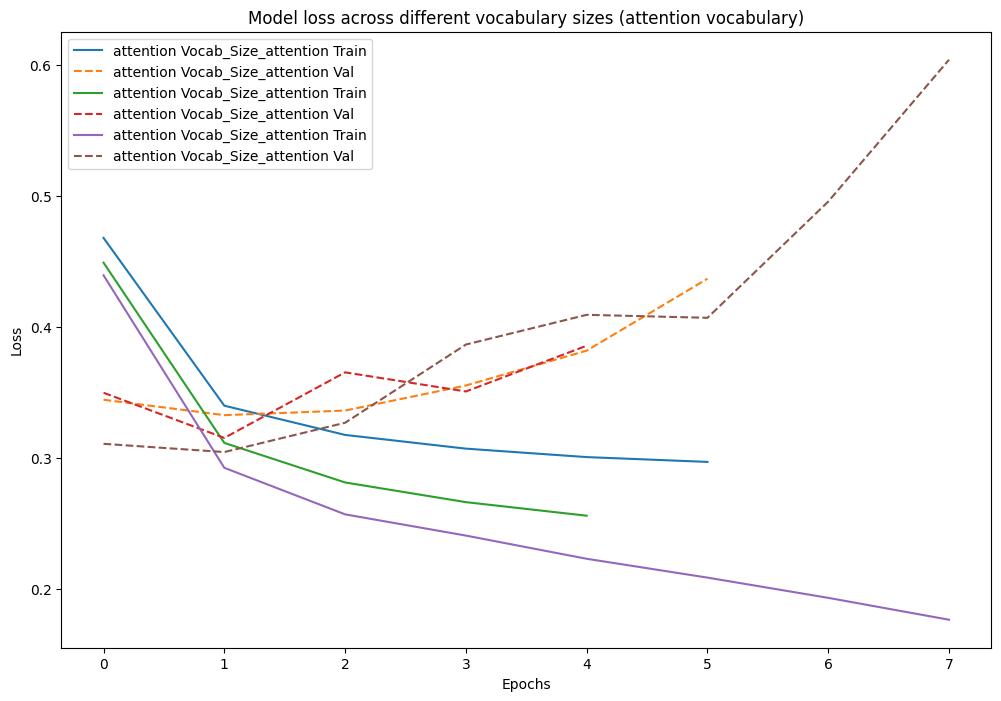

Model: cnn_gru, Vocab Size: cnn_gru, History Data: {'loss': [1.040091872215271, 0.369438111782074, 0.30606842041015625, 0.2748122215270996, 0.244817316532135, 0.21703453361988068], 'accuracy': [0.4915752410888672, 0.877419650554657, 0.898256242275238, 0.9106975197792053, 0.9219827651977539, 0.9322198033332825], 'val_loss': [0.4314296245574951, 0.3317030072212219, 0.31618043780326843, 0.3357604444026947, 0.3668075203895569, 0.37594369053840637], 'val_accuracy': [0.8529388904571533, 0.8849921822547913, 0.8920062780380249, 0.8864028453826904, 0.8786442279815674, 0.879741370677948]}
Model: cnn_gru, Vocab Size: cnn_gru, History Data: {'loss': [0.9908755421638489, 0.34080374240875244, 0.2733990550041199, 0.2379409223794937, 0.2036573588848114, 0.1727961301803589], 'accuracy': [0.521061897277832, 0.8887049555778503, 0.9117848873138428, 0.9249314069747925, 0.9373334646224976, 0.9487754702568054], 'val_loss': [0.3962623178958893, 0.31163859367370605, 0.3049745559692383, 0.313215434551239, 0.333

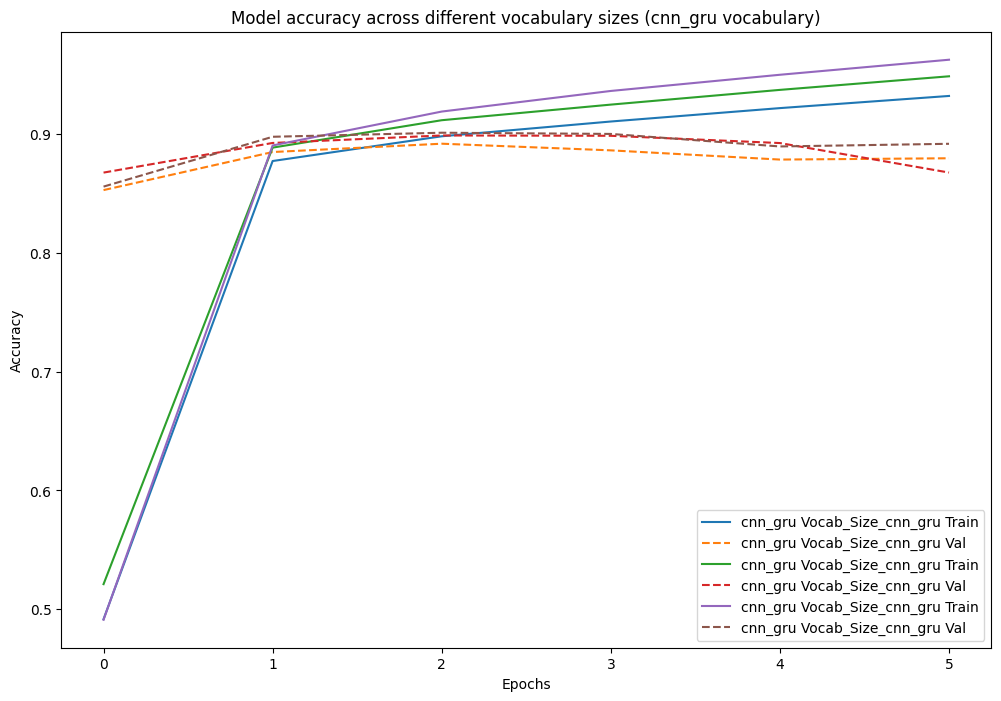

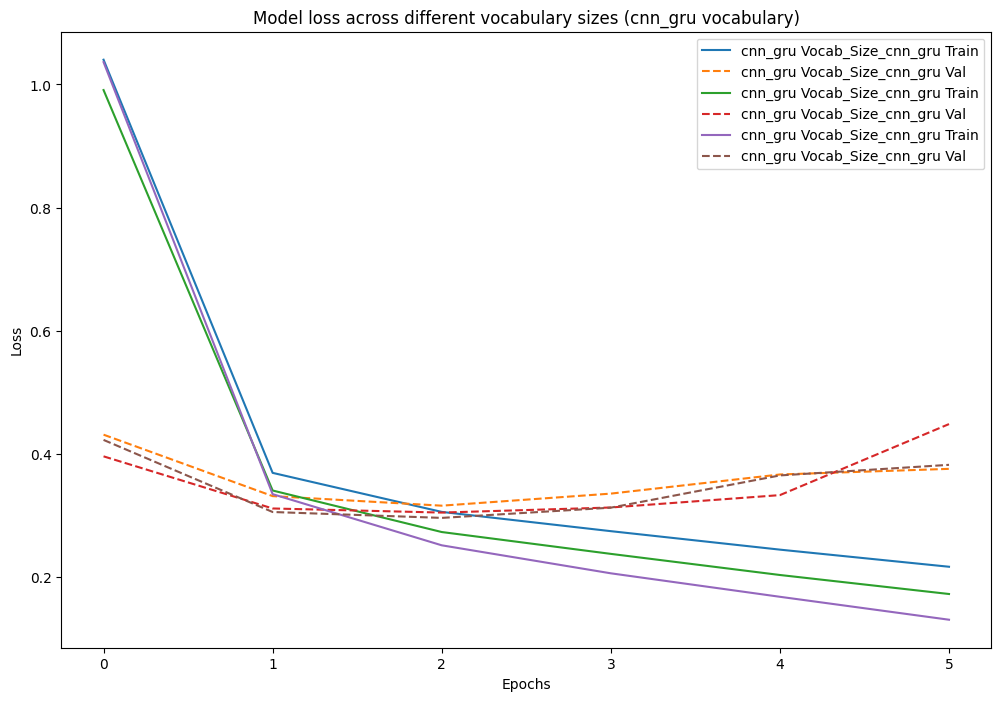

In [39]:
# Function to plot accuracy and loss for different vocabulary sizes and experiments
def plot_results(results_df):
    # Iterate over each unique experiment name
    for experiment_name in results_df['model_name'].unique():
        # Filter the DataFrame for the current experiment
        experiment_df = results_df[results_df['model_name'] == experiment_name]

        # Plot accuracy
        plt.figure(figsize=(12, 8))
        for index, row in experiment_df.iterrows():
            history = row['history']
            vocab_size = row['model_name']

            # Debugging: Print the contents of the history object
            print(f"Model: {experiment_name}, Vocab Size: {vocab_size}, History Data: {history.history}")

            if 'accuracy' in history.history and 'val_accuracy' in history.history:
                plt.plot(history.history['accuracy'], label=f'{experiment_name} Vocab_Size_{vocab_size} Train')
                plt.plot(history.history['val_accuracy'], label=f'{experiment_name} Vocab_Size_{vocab_size} Val', linestyle='--')
            else:
                print(f"Missing keys in history for model: {experiment_name}, vocab size: {vocab_size}")

        plt.title(f"Model accuracy across different vocabulary sizes ({experiment_name} vocabulary)")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

        # Plot loss
        plt.figure(figsize=(12, 8))
        for index, row in experiment_df.iterrows():
            history = row['history']
            vocab_size = row['model_name']

            if 'loss' in history.history and 'val_loss' in history.history:
                plt.plot(history.history['loss'], label=f'{experiment_name} Vocab_Size_{vocab_size} Train')
                plt.plot(history.history['val_loss'], label=f'{experiment_name} Vocab_Size_{vocab_size} Val', linestyle='--')
            else:
                print(f"Missing keys in history for model: {experiment_name}, vocab size: {vocab_size}")

        plt.title(f"Model loss across different vocabulary sizes ({experiment_name} vocabulary)")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

# Call the function with the DataFrame containing the results
plot_results(df)


1/1 [==============================] - 0s 84ms/step


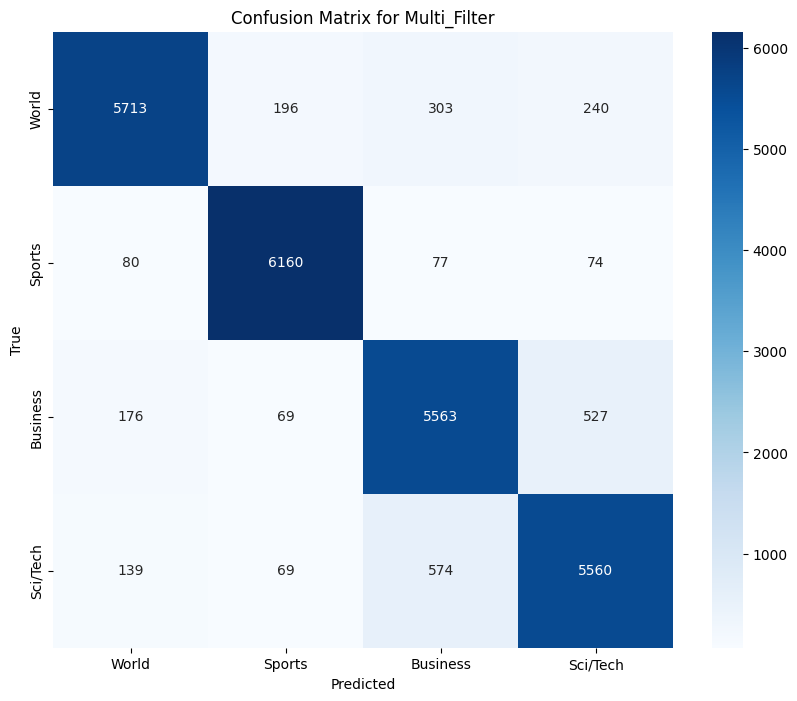

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot the confusion matrix
def plot_confusion_matrix(model, vectorizer, dataset, model_name):
    # Vectorize the test data
    def vectorize_text(text, label):
        text = vectorizer(text)
        return text, label

    vectorized_dataset = dataset.map(vectorize_text)
    test_data = vectorized_dataset.skip(int(0.8 * len(list(vectorized_dataset)))).take(int(0.2 * len(list(vectorized_dataset)))).batch(32)

    # Get true labels and predictions
    true_labels = []
    predictions = []

    for text_batch, label_batch in test_data:
        preds = model.predict(text_batch)
        predictions.extend(tf.argmax(preds, axis=1).numpy())
        true_labels.extend(label_batch.numpy())

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories.values(), yticklabels=categories.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Load the best models
multi_filter_model = models.load_model("multi_filter.h5")


# Plot confusion matrix for Multi_Filter model
plot_confusion_matrix(multi_filter_model, text_vectorization_and_adapt(dataset_all.map(lambda text, label: text), max_tokens=20000, standardize_fn=None, output_sequence_length=100), dataset_all, "Multi_Filter")

In [42]:
# Define function to evaluate the models
def evaluate_model(model, vectorizer, dataset):
    # Vectorize the test data
    def vectorize_text(text, label):
        text = vectorizer(text)
        return text, label

    vectorized_dataset = dataset.map(vectorize_text)
    test_data = vectorized_dataset.skip(int(0.8 * len(list(vectorized_dataset)))).take(int(0.2 * len(list(vectorized_dataset)))).batch(32)

    # Get true labels and predictions
    true_labels = []
    predictions = []

    for text_batch, label_batch in test_data:
        preds = model.predict(text_batch)
        predictions.extend(tf.argmax(preds, axis=1).numpy())
        true_labels.extend(label_batch.numpy())

    # Compute metrics
    f1 = f1_score(true_labels, predictions, average='weighted')
    accuracy = accuracy_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions, average='weighted')

    return f1, accuracy, recall


In [44]:
from sklearn.metrics import f1_score, accuracy_score, recall_score
# Evaluate the Multi_Filter model
multi_filter_vectorizer = text_vectorization_and_adapt(
    dataset_all.map(lambda text, label: text),
    max_tokens=20000,
    standardize_fn=None,
    output_sequence_length=100
)
multi_filter_f1, multi_filter_accuracy, multi_filter_recall = evaluate_model(
    multi_filter_model,
    multi_filter_vectorizer,
    dataset_all
)

# Print results for Multi_Filter model
print(f"Multi_Filter Model - F1 Score: {multi_filter_f1}, Accuracy: {multi_filter_accuracy}, Recall: {multi_filter_recall}")


1/1 [==============================] - 0s 18ms/step
Multi_Filter Model - F1 Score: 0.901203264844266, Accuracy: 0.9010971786833856, Recall: 0.9010971786833856
